# Multiple Regression

## key concepts
- For a slightly advanced model in the linear domain, we can add more variables (features) to our model.

$$
y_i = \beta_1 x_{i1} + \beta_2 x_{i2} + \beta_3 x_{i3} + \alpha + \varepsilon_i
$$

Where:
- $y_i$ = response (dependent) variable (response)
- $x_{i1}, x_{i2}, x_{i3}$ = predictor variables
- $\beta_1$, $\beta_2$, $\beta_3$ = coefficients
- $\alpha$ = intercept
- $\varepsilon_i$ = error term (noise)

> The $\varepsilon_i$ can be understood in better detail as :
> - Error term to represent that there are other factors not accounted for by this simple model.
> - In 3b1b term, model is trying to do _book-keeping_. [Reference](https://youtu.be/9-Jl0dxWQs8?si=35nObUMC-FQVgPPh)

-----------

## Multiple Linear regression intuition

- Model a response variable $y_i$ using multiple input features.

### Model:
$$
y_i = \beta_0 + \beta_1 x_{i1} + ... + \beta_k x_{ik} + \varepsilon_i
$$

#### In vector notation:

$$
y_i = \mathbf{x}_i \cdot \boldsymbol{\beta}
$$

Where:
- $\mathbf{x}i = [1, x_{i1}, x_{i2}, x_{i3}, .... x_{ik}]$ → input vector with a leading 1 for the intercept
- $\boldsymbol{\beta} = [\beta_0, \beta_1, \beta_2, \beta_3, ..., \beta_k]$ → parameter vector (includes intercept)

------------

In [1]:
import os
import tqdm

import numpy as np
os.chdir("..")

In [2]:
from support.linear_algebra import dot, Vector

def predict(x, beta):
    """Predicts y given input vector x and coeffecients beta.
    Assumes x[0] is 1 for the intercept term.
    """

    return dot(x, beta)

In [3]:
x_i = [1, 49, 4, 0] # [intercept, var-1, var-2, categorical variable 3]
beta = [1.0, 1.5, -2.0, 3.0] # example weights

predict(x_i, beta)

66.5

# Assumptions Behind Multiple Linear Regression (Least Squares)

### For multiple regression to work correctly and give reliable estimates, two key assumptions must hold:

1. No Perfect Multicollinearity

> No predictor `(e.g., var-2)` should be an exact linear combination of other predictors (e.g., var-1, var-3, etc.).

**Why is this important?**

> If one variable can be formed exactly by combining others, the model can’t determine how much weight to assign to each.
> It becomes impossible to uniquely estimate the coefficients.

------------------

2. No Correlation should exist b/w `Predictors` and `Errors`.

The model assumes that the input variables are ***not*** correlated with the error terms.

**Why does this matter?**
> If this assumption fails, the model can systematically mis-estimate the coefficients.
> Even if the predictors (features) look good individually, they may be indirectly masking the effect of others, leading to biased results.

------------------

#### Summary
- Predictors should be independent from each other.
- Predictors should also be independent from the errors.

If these assumptions are not met, the model might still work, but the results will be misleading. Coefficients will not reflect the correct underlying relationships.

------------------

## Fitting the model

> choosing the `beta` to minimise the sum of squared errors.
> *gradient descent* will be used.

In [4]:
from typing import List, Tuple

def error(x: Vector, y: float, beta: Vector) -> float:
    return predict(x, beta) - y 

def squared_error(x: Vector, y: float, beta: Vector) -> float:
    return error(x, y, beta) ** 2

In [5]:
x = [1,2,3]
y = 30
beta = [4,4,4] # so prediction = 4+8+12=24

In [6]:
assert error(x, y, beta) == -6
assert squared_error(x, y, beta) == 36

### Formula Behind `sqerror_gradient`

> The gradient of the squared error loss function wrt the parameter vector $\boldsymbol{\beta}$ is:

$$
\nabla_{\beta} \text{SE} = \frac{\partial}{\partial \beta} (y - \hat{y})^2 = -2 (y - \hat{y}) \cdot \mathbf{x}
$$

Or rewritten (since $\hat{y} = \mathbf{x} \cdot \boldsymbol{\beta}$):

$$
\nabla_{\beta} \text{SE} = 2 \cdot (\hat{y} - y) \cdot \mathbf{x}
$$

In [7]:
# using calculus

def sqerror_gradient(x: Vector, y: float, beta: Vector) -> Vector:
    err = error(x, y, beta)
    return [2 * err * x_i for x_i in x]

In [8]:
assert sqerror_gradient(x, y, beta) == [-12, -24, -36]

In [9]:
import random

from support.linear_algebra import vector_mean
from support.gradient_descent import gradient_step

def least_squares_fit(xs: List[Vector], 
                     ys: List[float], 
                     learning_rate: float = 0.001, 
                     num_steps: int = 1000, 
                     batch_size: int = 1) -> Tuple[Vector, List[Vector], List[float]]:
    """
    Find the beta that minimises the sum of squared errors 
    assuming the model y = dot(x, beta)

    Also, history of beta, & loss values.
    """

    # random initialisation
    guess = [np.random.random() for _ in xs[0]]

    beta_history = []
    loss_history = []
    
    for _ in tqdm.trange(num_steps, desc="least square fit"):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start+batch_size]
            batch_ys = ys[start:start+batch_size]

            gradient = vector_mean([sqerror_gradient(x, y, guess) 
                                    for x, y in zip(batch_xs, batch_ys)])
            guess = gradient_step(guess, gradient, -learning_rate)

        beta_history.append(guess[:]) # copy
        loss = sum((sum(x_i * b_i for x_i, b_i in zip(x, guess)) - y)**2 for x, y in zip(xs, ys))/len(xs)
        loss_history.append(loss)
        
    return guess, beta_history, loss_history

### Intuitive Explanation of `least_squares_fit` Function

This function tries to find the best line (or plane) that fits the given data. It does this by minimising the total error between the predicted and actual values. 

1. **Goal**: Find the best weights (`beta`) so that when we multiply them with input data (`x`), we get values close to the actual results (`y`). *This is called minimising squared error.*

2. **Start with a random guess**: We begin with a random guess for the weights.

3. **Iteratively improve the guess**:
   - For a number of steps (e.g., 1000 or more), we keep adjusting our guess.
   - In each step, we take a small batch of data points.
   - For each point in the batch, we calculate the error and how to reduce it (the gradient).
   - We average these gradients for the batch.
   - Then we slightly move our guess in the direction that reduces the error (this is gradient descent).

4. **Repeat until good enough**: By doing this many times, our guess (the weights) becomes better and better at predicting the right values.

5. **Return final weights**: After all steps, we return the weights that give the smallest error.

In short:  
_We start with a bad guess, measure how wrong it is, and keep tweaking it step by step until it's good._

--------------------

In [10]:
import matplotlib.pyplot as plt

def plot_predictions(xs, ys, beta):
    """
    Plot actual vs predicted values for visual understanding.
    Works well when input has one feature + intercept.
    """
    # Assuming xs are [1, x1] (intercept + one feature)
    xs_feature = [x[1] for x in xs]
    preds = [sum(x_i * b_i for x_i, b_i in zip(x, beta)) for x in xs]

    plt.scatter(xs_feature, ys, color='blue', label='Actual')
    plt.plot(xs_feature, preds, color='red', label='Predicted')
    plt.xlabel("Feature")
    plt.ylabel("Target")
    plt.title("Actual vs Predicted")
    plt.legend()
    plt.grid(True)
    plt.show()

### least_square_fit function
> Generic function which will work with any dataset.

In [11]:
from support.predefined_data import daily_minutes_good, inputs
from support.gradient_descent import gradient_step

np.random.seed(123)
learning_rate=0.001

beta, beta_h, loss_h = least_squares_fit(inputs, daily_minutes_good, learning_rate, 5000, 25)

assert 24.60 < beta[0] < 24.62  # constant
assert  0.84 < beta[1] < 0.85   # num_friends
assert -0.25 < beta[2] < -0.23 # work hours per day
assert  0.008 < beta[3] < 0.01 # has PhD

least square fit: 100%|██████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3398.84it/s]


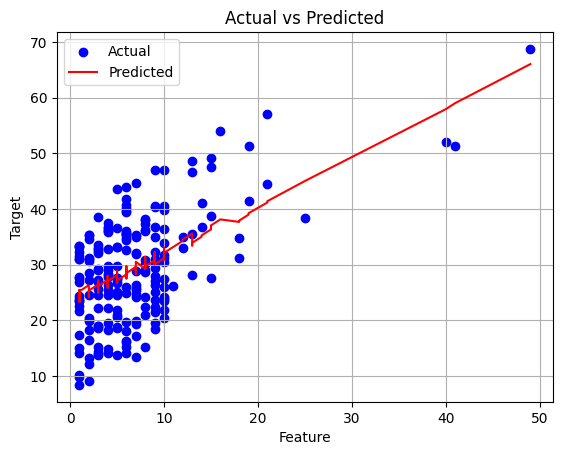

In [12]:
plot_predictions(inputs, daily_minutes_good, beta)

In [13]:
def plot_loss_curve(loss_history):
    plt.plot(loss_history)
    plt.xlabel("Iteration")
    plt.ylabel("Loss (MSE)")
    plt.title("Loss Curve During Optimization")
    plt.grid(True)
    plt.show()

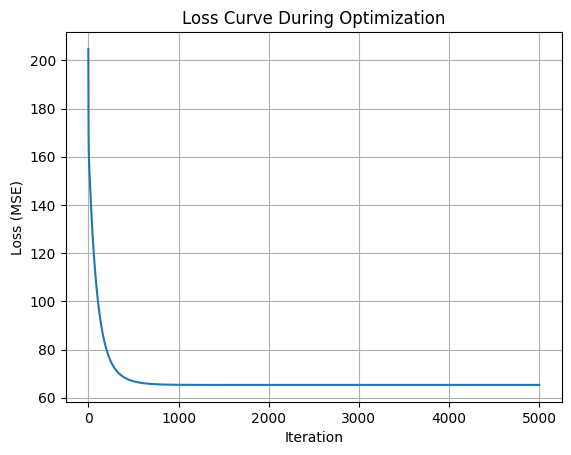

In [14]:
plot_loss_curve(loss_h)

### Goodness of fit

In [15]:
from support.simple_linear_regression import total_sum_of_squares

def multiple_r_squared(xs: List[Vector], ys: Vector, beta: Vector) -> float:
    sum_of_squared_errors = sum(error(x, y, beta) ** 2 
                                for x, y in zip(xs, ys))
    return 1.0 - sum_of_squared_errors / total_sum_of_squares(ys)

In [16]:
assert 0.32 < multiple_r_squared(inputs, daily_minutes_good, beta) < 0.33

## Intuition Behind Adding Variables in Regression and Coefficient Confidence

### 1. **Adding More Variables Increases R-squared (But Be Careful)**
When we add more input variables (features) to a regression model, the model will always fit the data *at least as well* as before, better even. Why?

Because the simple regression (say, only using `num_friends`) is just a special case of a bigger model (say, using `num_friends`, `work_hours`, and `has_phd`) where the extra variables have zero effect (their coefficients are 0).

**Key point**: R-squared will always go up or stay the same when you add more variables — even if those variables are useless. So we shouldn't rely on R-squared alone to decide if a model is better.

---

### 2. **Check Standard Errors to Trust Coefficients**
Even if your model has a great R-squared, that doesn’t mean every coefficient (each β value) is meaningful.

Because if your input variables are:
- **Highly correlated** (e.g. work_hours and has_phd),
- Or **not actually useful**,  

Then the model might give random-ish β values for those inputs just to force a better fit.

To judge how reliable each coefficient is, we look at its **standard error** — this tells us how confident the model is about that particular β.

---

### 3. **What Do Standard Errors Actually Assume?**
We assume:
- The model errors (ε) are **random**, **independent**, and **normally distributed** with mean 0.
- All errors share a common standard deviation (σ).

With this assumption, we can calculate how “noisy” or “reliable” each β is using standard errors.

---

### TL;DR
- **More features ≠ better model** — they just fit the data better on paper.
- Always check **standard errors** to know which features really matter.
- Leave the math to the libraries, and focus on interpreting the outputs wisely.

## Bootstrap

In [17]:
from typing import TypeVar, Callable

X = TypeVar('X') # generic type for data
Stat = TypeVar('Stat') # generic type for 'statistic'

def bootstrap_sample(data: List[X]) -> List[X]:
    """randomly samples len(data) elements with replacement"""
    return [random.choice(data) for _ in data]

def bootstrap_statistic(data: List[X], 
                        stats_fn: Callable[[List[X]], Stat], 
                        num_samples: int) -> List[Stat]:
    """evaluates stats_fn on num_samples boostrap samples from data"""
    return [stats_fn(bootstrap_sample(data)) for _ in range(num_samples)]

In [18]:
# 101 points close to 100
close_to_100 = [99.5 + np.random.random() for _ in range(101)]

# 101 points, 50 of them near 0, 50 of them near 200
far_from_100 = ([99.5 + np.random.random()] +
                [np.random.random() for _ in range(50)] +
                [200 + np.random.random() for _ in range(50)])

In [19]:
from support.statistics import median, stddev

medians_close = bootstrap_statistic(close_to_100, median, 100)

In [20]:
medians_far = bootstrap_statistic(far_from_100, median, 100)

In [21]:
assert stddev(medians_close) < 1
assert stddev(medians_far) > 90

### Standard errors of regression coefficients

> I didn't find the writings in the book intuitive, so **here is my version**
--------

## What Are Standard Errors of Regression Coefficients?

When you run a regression, your model gives you numbers (called **coefficients**) for each feature. Like:

- β₀ = constant
- β₁ = effect of number of friends
- β₂ = effect of work hours
- β₃ = effect of PhD

### But how reliable are those numbers?

They come from your **sample** of data, if you used a different sample, you'd probably get slightly different results.

So let's ask: **How much would each β value change if we repeat the regression with different data samples?**

---

## Bootstrapping: The Simple Idea

1. Take a random sample *with replacement* from your data.
2. Run the regression on that sample → get a new β.
3. Repeat this 100+ times → you get 100+ sets of βs.
4. **Look at how much each coefficient varies across samples.**

If a coefficient (say, for `num_friends`) stays almost the same every time, that means it’s **stable and reliable**.

If it jumps all over the place? That means it’s **noisy and untrustworthy**.

---

## How We Measure This: Standard Error

Just take the **standard deviation** of all the bootstrapped βs for each feature. This is a measure of **how uncertain** it is about each β.

What are we trying to do with this?

We test: “Could this coefficient actually be zero?”

> Example: if β = 0.972 and its standard error = 0.103 : that’s a tight estimate. It’s very unlikely to be zero. That variable (like `num_friends`) is useful.

> But if β = 0.923 and std error = 1.249 : that’s messy. Could easily be just random noise. Maybe `has_phd` doesn’t really affect the outcome.

------

## TL;DR
* Bootstrapping = repeat regression on different samples to see how stable each β is.
* Standard error = how much each β varies.
* Big standard error = we’re not confident about that feature’s effect.
* Use this to tell which variables matter and which are probably noise.
-----

In [22]:
def estimate_sample_beta(pairs: List[Tuple[Vector, float]], print_flag=False):
    x_sample = [x for x, _ in pairs]
    y_sample = [y for _, y in pairs]

    beta, _, _ = least_squares_fit(x_sample, y_sample, learning_rate, 5000, 25)
    if print_flag:
        print("bootstrap_sample", beta)
    return beta

In [23]:
np.random.seed(123)

In [24]:
bootstrap_betas = bootstrap_statistic(list(zip(inputs, daily_minutes_good)), estimate_sample_beta, 10)

least square fit: 100%|██████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3360.59it/s]


In [25]:
# standard deviation of each coeffecient

bootstrap_standard_errors = [stddev([beta[i] for beta in bootstrap_betas]) 
                             for i in range(4)]

In [26]:
print(bootstrap_standard_errors)

[3.0524640365766813, 0.3842709178677799, 0.7947308724101233, 3.8443670797786926]


In [27]:
from support.probability import normal_cdf
def p_value(beta_hat_j: float, sigma_hat_j: float) -> float:
    if beta_hat_j > 0:
        # if the coefficient is positive, we need to compute twice the
        # probability of seeing an even *larger* value
        return 2 * (1 - normal_cdf(beta_hat_j / sigma_hat_j))
    else:
        # otherwise twice the probability of seeing a *smaller* value
        return 2 * normal_cdf(beta_hat_j / sigma_hat_j)

In [28]:
assert p_value(30.58, 1.27) < 0.001 # constant term
assert p_value(0.972, 0.103) < 0.001 # num_friends
assert p_value(-1.865, 0.155) < 0.001 # work_hours
assert p_value(0.923, 1.249) > 0.4 # phd

## What Is the `p-value` Telling Us in Regression?

The **p-value** tells you how likely it is that a given regression coefficient (β) is actually **just noise** — i.e., **not really important**.

---

### Imagine This:

Let’s say the coefficient for `num_friends` is 0.972, with a standard error of 0.103.

Now we ask:
> “What if the true value of this coefficient is actually 0 (meaning `num_friends` doesn’t matter)?”

The **p-value** answers:
> “If `num_friends` had no real effect, what are the chances we’d see a coefficient this large just by random chance?”

---

### Low p-value (e.g., < 0.05):
- It’s **unlikely** that we’d see such a big effect by chance.
- So we say: _“This feature probably matters.”_

### High p-value (e.g., > 0.4):
- It’s **totally possible** that we got this value by luck.
- So we say: _“This feature might just be noise.”_

---

### In Your Example:

| Feature      | Coefficient | Std. Error | p-value | Interpretation                          |
|--------------|-------------|------------|---------|------------------------------------------|
| Constant     | 30.58       | 1.27       | < 0.001 | Very significant                         |
| Num Friends  | 0.972       | 0.103      | < 0.001 | Definitely meaningful                    |
| Work Hours   | -1.865      | 0.155      | < 0.001 | Definitely meaningful                    |
| Has PhD      | 0.923       | 1.249      | > 0.4   | Probably **not** meaningful (just noise) |

---

### TL;DR

- **p-value = evidence strength**
- Small p-value → strong evidence that the variable matters
- Big p-value → might be noise, ignore cautiously

## Regularisation

## Intuition: What Is Regularization in Regression?

When you have **many input features**, your model can easily **overfit** the training data — meaning it learns noise rather than signal.

Also, if your goal is **interpretability**, a model with just a few meaningful coefficients is easier to understand than one with dozens.

### Regularization helps solve both problems:
1. It prevents **overfitting**.
2. It encourages **simpler, cleaner models** (fewer or smaller coefficients).

---

## How It Works

Normally, regression minimizes this:

$$Total Error = \sum (actual - predicted)²$$

With **regularization**, we add a penalty for big coefficients:

$$Total Error = \sum (actual - predicted)² + penalty(beta)$$

----

Now, even if your model could improve accuracy by giving huge weight to a variable, the penalty discourages it.

---

### Two Common Types of Regularization

#### 1. **Ridge Regression** (L2 penalty)
- Penalizes large coefficients.
- Keeps all features, but shrinks their values.
- Penalty: **sum of squares of coefficients**


In [29]:
def ridge_penalty(beta: Vector, alpha: float) -> float:
    return alpha * dot(beta[1:], beta[1:])  # skip beta[0]

In [30]:
## Loss Function with Ridge
def squared_error_ridge(x: Vector, y: float, beta: Vector, alpha: float) -> float:
    return error(x, y, beta) ** 2 + ridge_penalty(beta, alpha)

In [31]:
## Gradient for Ridge

from support.linear_algebra import add
def ridge_penalty_gradient(beta: Vector, alpha: float) -> Vector:
    return [0.] + [2 * alpha * b for b in beta[1:]]  # beta[0] is untouched

def sqerror_ridge_gradient(x: Vector, y: float, beta: Vector, alpha: float) -> Vector:
    return add(sqerror_gradient(x, y, beta), ridge_penalty_gradient(beta, alpha))

#### 2. Lasso Regression (L1 penalty)
- Pushes many coefficients to zero, making the model sparse.
- Great for feature selection.
- Penalty: sum of absolute values of coefficients

In [32]:
def lasso_penalty(beta: Vector, alpha: float) -> float:
    return alpha * sum(abs(b) for b in beta[1:])

Lasso doesn’t work well with gradient descent due to sharp corners in the absolute value function, so we typically use special solvers like coordinate descent for it.

⸻

**Practical Effect of Increasing Alpha**

| Alpha (Penalty Strength) | Coefficients Shrink | Fit Gets Worse | Interpretation       |
|--------------------------|---------------------|----------------|----------------------|
| 0                        | No penalty          | Best fit       | Can overfit          |
| 0.1 – 1.0                | Mild penalty        | Still good fit | Safer model          |
| 10+                      | Strong penalty      | Fit drops      | Simpler model        |

E.g., in Ridge:
* beta_PHD drops from 0.91 → 0.54 → 0.10 → ~0
* Model gets simpler, but might lose a bit of accuracy

⸻

### One Important Note

Always rescale (normalize) your data before applying regularization!

Otherwise, variables with big units (like “years” vs “age in decades”) will get penalized unfairly just because of their scale.

⸻

TL;DR
* Regularization = shrink or eliminate coefficients to prevent overfitting
* Ridge (L2): shrinks coefficients → good when all features matter
* Lasso (L1): kills unimportant ones → good for sparse, interpretable models
* Higher alpha = simpler, but possibly less accurate model

In [33]:
def least_squares_fit_ridge(xs: List[Vector],
                            ys: List[float],
                            alpha: float,
                            learning_rate: float = 0.001,
                            num_steps: int = 1000,
                            batch_size: int = 1) -> Vector:
    guess = [np.random.random() for _ in xs[0]]

    for _ in tqdm.trange(num_steps, desc="ridge fit"):
        for start in range(0, len(xs), batch_size):
            batch_xs = xs[start:start+batch_size]
            batch_ys = ys[start:start+batch_size]

            gradient = vector_mean([
                sqerror_ridge_gradient(x, y, guess, alpha)
                for x, y in zip(batch_xs, batch_ys)
            ])
            guess = gradient_step(guess, gradient, -learning_rate)

    return guess

In [34]:
import matplotlib.pyplot as plt
import numpy as np

def plot_ridge_effect(alphas: List[float], betas: List[Vector], r_squareds: List[float]):
    betas = np.array(betas)  # shape: (len(alphas), num_features)
    
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # 1. Coefficients vs Alpha
    for i in range(1, betas.shape[1]):  # skip beta[0]
        axs[0].plot(alphas, betas[:, i], label=f'beta_{i}')
    axs[0].set_title("Ridge Coefficients vs Alpha")
    axs[0].set_xlabel("Alpha (Penalty Strength)")
    axs[0].set_ylabel("Coefficient Value")
    axs[0].legend()
    axs[0].grid(True)

    # 2. R^2 vs Alpha
    axs[1].plot(alphas, r_squareds, marker='o', color='red')
    axs[1].set_title("Model Fit (R²) vs Alpha")
    axs[1].set_xlabel("Alpha")
    axs[1].set_ylabel("R² Score")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

ridge fit: 100%|█████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 2987.05it/s]


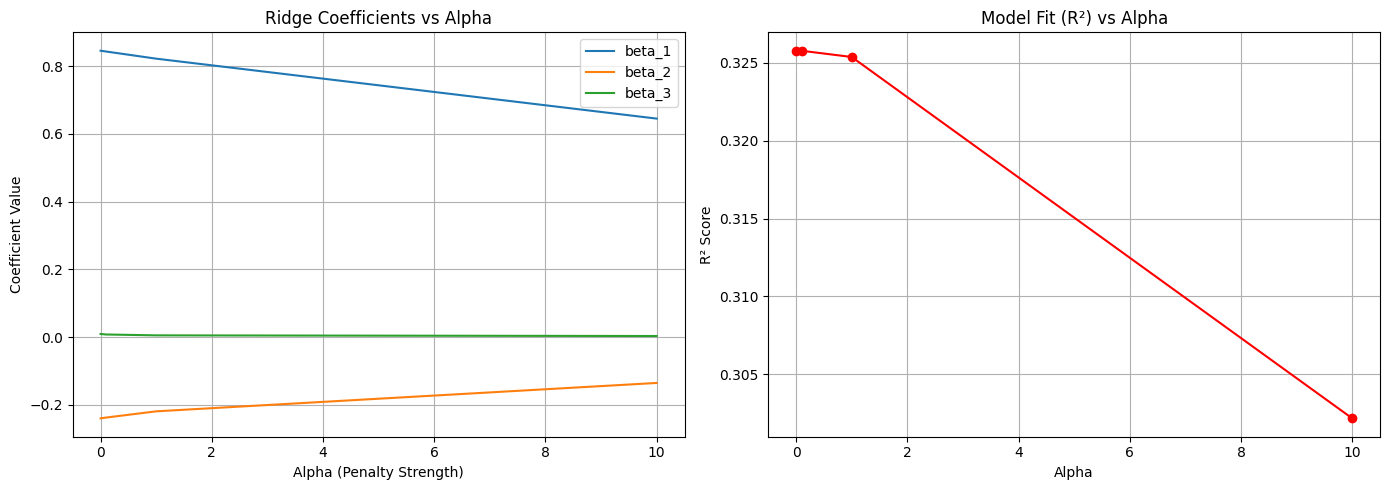

In [35]:
alphas = [0.0, 0.1, 1, 10]
betas = []
r2_scores = []

for alpha in alphas:
    beta = least_squares_fit_ridge(inputs, daily_minutes_good, alpha, learning_rate, 5000, 25)
    betas.append(beta)
    r2_scores.append(multiple_r_squared(inputs, daily_minutes_good, beta))

plot_ridge_effect(alphas, betas, r2_scores)

-----
# Script Complete